
## Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet & Hugo Bordereaux.

**Dataset**: CMU Movie Summary Corpus

# Part 3: Textual Analysis

In this notebook, we analyze the pre-processed output of our custom CoreNLP pipeline. 

### Table of contents
1. [Loading pre-processed coreNLP data](#section1)
2. [Persona clusters](#section2)
    - 2.1. [Embedding descriptions](#section2-1)
    - 2.2. [Weighted average of word vectors](#section2-2)
    - 2.3. [Dimensionality reduction](#section2-3)
        - 2.3.1. [Principal Component Analysis (PCA)](#section2-3-1)
        - 2.3.2. [*t*-distributed Stochastic Neighbor Embedding (t-SNE)](#section2-3-2)
    - 2.4. [Clustering personas](#section2-4)
    - 2.5. [Visualizing persona clusters](#section2-5)
    - 2.6. [Labelling persona clusters](#section2-6)
    - 2.7. [Preparing data for website use](#section2-7)

**Prerequisite**: 

Install [spaCy](https://spacy.io) using the following commands: 

        pip install spacy
        
        python3 -m spacy download en_core_web_sm

In [16]:
import os
import pickle
import spacy
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from ast import literal_eval
import random

from extraction import *
from coreNLP_analysis import *
from load_data import *
from textual_analysis import *


# NOTE: If you haven't loaded NLTK before, set this to True
load_nltk = False

if load_nltk: #Load the spaCy model for the semantic analysis
    nlp_spacy = spacy.load("en_core_web_lg")

pd.options.mode.chained_assignment = None

random.seed(0)

## 1. Load pre-processed coreNLP data <a class="anchor" id="section1"></a>

We first load the pre-processed output from our custom CoreNLP pipeline. 

In [17]:
char_description_path = 'Data/CoreNLP/char_descriptions.csv'
full_description_path = 'Data/CoreNLP/full_descriptions.csv'

# Load character descriptions
char_description_df = pd.read_csv(char_description_path, sep='\t', index_col=None, low_memory=False)

# Convert to lists
char_description_df['agent_verbs'] = char_description_df.agent_verbs.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['patient_verbs'] = char_description_df.patient_verbs.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['attributes'] = char_description_df.attributes.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['descriptions'] = char_description_df.descriptions.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['title'] = char_description_df.title.apply(
    lambda x: literal_eval(x) if type(x) == str else x)

full_description_df = pd.read_csv(full_description_path, sep='\t', index_col=None, low_memory=False)
relations_df = pd.read_csv('Data/CoreNLP/char_relations.csv', sep='\t', index_col=None, low_memory=False)
char_df = load_char_df()

## 2. Persona clusters <a class="anchor" id="section2"></a>

### 2.1. Embedding descriptions <a class="anchor" id="section2-1"></a>

We embed all descriptive words (actions, attributes, titles) of all characters into a high-dimensional vector space using spaCy. 

In [9]:
embedding_file = 'Data/CoreNLP/char_description_embeddings.pickle'

# If we have already embedded the descriptions, load them from the pickle file
if os.path.exists(embedding_file):
    char_description_df = pd.read_pickle(embedding_file)

else:
    # Embed descriptions (Get a comfy chair, this takes a while) 
    char_description_df = construct_descriptions_embeddings(char_description_df, nlp_spacy)

    # Split embeddings by category
    char_description_df = embeddings_categorical(char_description_df)

    # Save the embeddings to a pickle file
    with open(embedding_file, 'wb') as f:
        pickle.dump(char_description_df, f)

### 2.2. Weighted average of word vectors <a class="anchor" id="section2-2"></a>

We then weigh the word embedding of each word for each character by their cosine distance to the average semantic vector of words with the sam type used for all characters in the dataset. The *cosine distance* is defined as:

$$\text{cosine distance}(x_1, x_2) = 1-\frac{x_1 \cdot x_2}{||x_1||\cdot||x_2||}$$

where $x_1$ and $x_2$ are the vector representations of two words.

In [10]:
weight_df = weight_embeddings(char_description_df, column='title', percentile=0)

weight_df = weight_embeddings(weight_df, column='attributes', percentile=60)

weight_df = weight_embeddings(weight_df, column='agent_verbs', percentile=75)

weight_df = weight_embeddings(weight_df, column='patient_verbs', percentile=85)

weight_df = weight_embeddings(weight_df, column='descriptions', title_weight=0.35)

### 2.3. Dimensionality reduction <a class="anchor" id="section2-3"></a>

#### 2.3.1. Principal Component Analysis (PCA) <a class="anchor" id="section2-3-1"></a>

To visualize our clusters, we then map these high-dimensional descriptive vectors to 50-dimensional space using PCA to prepare the ground for a second dimensionality reduction technique. 

Keep only the relations where the wikipedia ID is the same for both characters (they are in the same movie)

In [ ]:
relations_df['subject wikipedia ID'] = relations_df['Subject freebase character ID'].apply(
    lambda x: char_df[char_df['Freebase character ID'] == x]['Wikipedia ID'].values[0] if type(x) == str else x)
relations_df['object wikipedia ID'] = relations_df['Object freebase character ID'].apply(
    lambda x: char_df[char_df['Freebase character ID'] == x]['Wikipedia ID'].values[0] if type(x) == str else x)
# find the indices of rows in relations_df where both subject wikipedia ID and object wikipedia ID are not NaN and they are not equal
indices = relations_df[(relations_df['subject wikipedia ID'].notnull()) & (relations_df['object wikipedia ID'].notnull()) & (
    relations_df['subject wikipedia ID'] != relations_df['object wikipedia ID'])].index
# remove these rows from relations_df
relations_df = relations_df.drop(indices)
# remove the columns 'subject wikipedia ID' and 'object wikipedia ID'
relations_df = relations_df.drop(
    columns=['subject wikipedia ID', 'object wikipedia ID'])
# Keep only the rows in relations_df where the Subject freebase character ID and Object freebase character ID are both not NaN
relations_df = relations_df[(relations_df['Subject freebase character ID'].notnull()) & (
    relations_df['Object freebase character ID'].notnull())]
# Get a set of the freebase character IDs in relations_df
freebase_ids = set(relations_df['Subject freebase character ID'].unique()).union(
    set(relations_df['Object freebase character ID'].unique()))

# Add a dummy column to df called 'in_relation' which is True if the freebase character ID is in freebase_ids and False otherwise
weight_df['in_relation'] = weight_df['Freebase character ID'].apply(
    lambda x: x in freebase_ids if type(x) == str else False)


In [11]:
# Remove rows in char_description_df that have less than X descriptions
min_words_non_rel = 5
min_words_rel = 2
df = weight_df.copy(deep=True)
df = df[df.descriptions.apply(lambda x: type(x) != float)]

# For characters that are not in a relation, keep only rows with at least min_words_non_rel descriptions
df = df[(df.in_relation == False) | (df.descriptions.apply(lambda x: len(x) >= min_words_rel))]

# For characters that are in a relation, keep only rows with at least min_words_rel descriptions
df = df[(df.in_relation == True) | (df.descriptions.apply(lambda x: len(x) >= min_words_non_rel))]

# Print percentage of characters kept
print('Percentage of characters kept: {:.2f}%'.format(100*len(df)/len(weight_df)))


Percentage of characters with at least 5 descriptions: 56.01%


In [12]:
# Dimensionality reduction: PCA to 50 dimensions -> t-SNE to 3 dimensions
column = 'weighted_descriptions_embeddings'
n_total = df[column].apply(lambda x: 1 if type(x) == np.ndarray else 0).sum()
#pca_df = descriptions_PCA(df, column=column, n_components=50)

#### 2.3.2. *t*-distributed Stochastic Neighbor Embedding (t-SNE) <a class="anchor" id="section2-3-2"></a>

We now perform [t-SNE dimensionality reduction](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) on the pre-reduced weighted embeddings. 

In [13]:
column = 'weighted_descriptions_embeddings'

# If loaded, load the embeddings from the pickle file
pickle_file = 'Data/CoreNLP/char_description_embeddings_tsne.pickle'
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        tsne_df = pickle.load(f)

else: 
    # t-SNE reduction (this takes a few minutes to run)
    tsne_df = descriptions_tSNE(pca_df, column=column, n_components=3, learning_rate='auto')

    # Save the embeddings to a pickle file
    pickle_file = 'Data/CoreNLP/char_description_embeddings_tsne.pickle'
    with open(pickle_file, 'wb') as f:
        pickle.dump(tsne_df, f)

### 2.4. Clustering personas <a class="anchor" id="section2-4"></a>

The persona point cloud is clustered into several categories using [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). This clustering method is mainly parameterized by $\varepsilon$ (`eps`), corresponding to the "maximum distance between two samples for one to be considered as in the neighborhood of the other", and `min_samples`, which is "the number of samples in a neighborhood for a point to be considered as a core point."

In [14]:
def collapse_center(cluster_df, factor=2):
    ''' Divide the norm of each point (X,Y,Z) in the central cluster by 2'''
    cluster_df = cluster_df.copy(deep=True)

    # Get the cluster with lowest average norm (X, Y, Z)
    cluster_df['norm'] = np.sqrt(cluster_df['tsne_1_weighted_descriptions_embeddings']**2 +
                                 cluster_df['tsne_2_weighted_descriptions_embeddings']**2 + cluster_df['tsne_3_weighted_descriptions_embeddings']**2)
    cluster_df['norm'] = cluster_df['norm'].apply(
        lambda x: x if type(x) == float else 0)

    # Get cluster labels with lowest average norm
    central_cluster = cluster_df.groupby('labels')['norm'].mean().idxmin()
    print('Central cluster: {}'.format(central_cluster))

    # Divide norm by factor for central cluster
    cluster_df.loc[cluster_df['labels'] == central_cluster, 'tsne_1_weighted_descriptions_embeddings'] = cluster_df.loc[cluster_df['labels']
                                                                                                                        == central_cluster, 'tsne_1_weighted_descriptions_embeddings'].apply(lambda x: x/factor)
    cluster_df.loc[cluster_df['labels'] == central_cluster, 'tsne_2_weighted_descriptions_embeddings'] = cluster_df.loc[cluster_df['labels']
                                                                                                                        == central_cluster, 'tsne_2_weighted_descriptions_embeddings'].apply(lambda x: x/factor)
    cluster_df.loc[cluster_df['labels'] == central_cluster, 'tsne_3_weighted_descriptions_embeddings'] = cluster_df.loc[cluster_df['labels']
                                                                                                                        == central_cluster, 'tsne_3_weighted_descriptions_embeddings'].apply(lambda x: x/factor)
    return cluster_df


In [ ]:
# DBSCAN parameters:
eps = 7.4
min_samples = 112

# Run DBSCAN clustering
cluster_df, n_clusters, n_removed = DBSCAN_cluster(
    tsne_df, column, method='tsne', eps=eps, min_samples=min_samples)
cluster_df = collapse_center(cluster_df, factor=1.2)


### 2.5. Visualizing persona clusters <a class="anchor" id="section2-5"></a>

The clustered persona point cloud is shown below. 

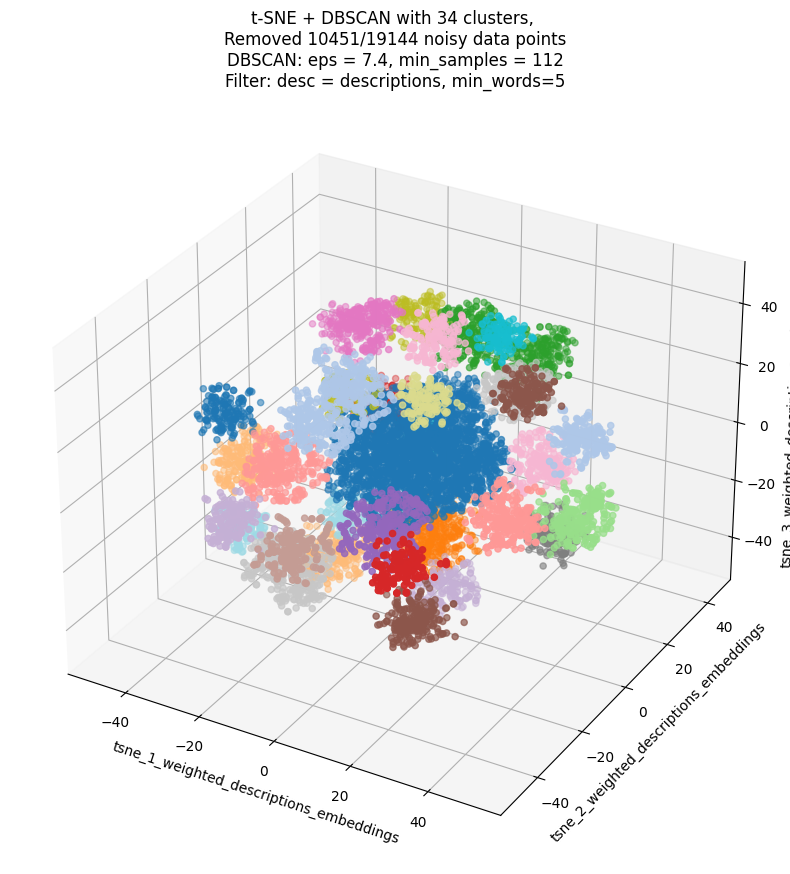

In [15]:
# Count number of rows in relations_df where the Subject freebase character ID and Object freebase character ID are both in Freebase character ID of cluster_df
n_relations = relations_df[(relations_df['Subject freebase character ID'].isin(cluster_df['Freebase character ID'])) & (
    relations_df['Object freebase character ID'].isin(cluster_df['Freebase character ID']))].shape[0]
n_rem_rel = len(relations_df)-n_relations

title = ''
title = 't-SNE + DBSCAN with {} clusters, \nRemoved {}/{} noisy data points\nRemoved {}/{} relations\nDBSCAN: eps = {}, min_samples = {}\nFilter: desc = {}, min_words={}'.format(
    n_clusters, n_removed, n_total, n_rem_rel, len(relations_df), eps, min_samples, 'descriptions', min_words_non_rel)
plot_clusters_3d(cluster_df, title, column=column)


### 2.7. Preparing data for website use <a class="anchor" id="section2-7"></a>

We now aggregate all of our data into a single `.csv`file that will be used as the basis of our point cloud on the website. This includes movie metadata, character metadata, actor metadata and embedded character descriptions. 

In [52]:

df = cluster_df.copy(deep=True)

df = filter_descriptions(df)

df = df.drop(columns=['descriptions_embeddings', 'attributes_embeddings', 'title_embeddings',
                                      'agent_verbs_embeddings', 'patient_verbs_embeddings', 'weighted_title_embeddings',
                                      'weighted_attributes_embeddings', 'weighted_agent_verbs_embeddings', 'weighted_patient_verbs_embeddings',
                                      'weighted_descriptions_embeddings'])

df.rename(columns={
    'tsne_1_weighted_descriptions_embeddings': 'X',
    'tsne_2_weighted_descriptions_embeddings': 'Y',
    'tsne_3_weighted_descriptions_embeddings': 'Z'},
    inplace=True)

# Delete columns from full_description_df
full_descr = full_description_df.copy(deep=True)
full_descr = full_descr.drop(columns=['Character name', 'title', 'religion', 'children', 'all_descriptions',
                                                        'Freebase ID', 'Date of birth', 'Freebase character/map ID', 'Freebase actor ID'])

# Remove duplicates, based on Freebase character ID
final_df = df.drop_duplicates(subset=['Freebase character ID'])

# Merge on Freebase character ID
final_df = df.merge(
    full_descr, on='Freebase character ID', how='left')

# Convert release date to year
final_df['Release date'] = final_df['Release date'].apply(
    lambda x: int(x.split('-')[0]) if type(x) == str else x)

#Load tsv file from 'Data/CoreNLP/MovieSummaries/movie.metadata.tsv'
metadata_df = load_movie_df()

# Merge with final_df on Wikipedia ID, keep from metadata_df only the column 'Name'
final_df = final_df.merge(
    metadata_df[['Box office revenue', 'Genres', 'Wikipedia ID', 'Name']], on='Wikipedia ID', how='left')

# Remove columns
final_df = final_df.drop(
    columns=['age', 'plot_name'])

# Get a dictionary of each genre and the number of times it appears in metadata_df
genre_dict = {}
for genres in metadata_df['Genres']:
   # type is list of strings
   if type(genres) == list:
    for genre in genres:
        if genre in genre_dict:
            genre_dict[genre] += 1
        else:
            genre_dict[genre] = 1

# For each row in final_df, from column 'Genres', keep the 3 genres that have the highest value in genre_dict
final_df['Genres'] = final_df['Genres'].apply(
    lambda x: sorted(x, key=lambda genre: genre_dict[genre], reverse=True)[:3] if type(x) == list else x)

# Save final_df to a csv file
final_df.to_csv(
    'Data/CoreNLP/final_df.csv', sep='\t', index=False)


## 3. Clustering analysis



### Load final df

In [ ]:
# Load final_df from csv file
final_df = pd.read_csv('Data/CoreNLP/final_df.csv', sep='\t')
# Load relations.csv
relations_df = pd.read_csv('Data/CoreNLP/char_relations.csv', sep='\t')
# Load movie metadata
metadata_df = load_movie_df()
# Rename movie_id to Wikipedia ID
relations_df.rename(columns={'movie_id': 'Wikipedia ID'}, inplace=True)
#load char_df
char_df = load_char_df()



### Add relations

In [ ]:
relations_df_final = relations_df.copy()
# Get a subset of relations_df where the Subject freebase character ID and Object freebase character ID are in final_df
relations_df_final = relations_df[relations_df['Subject freebase character ID'].isin(final_df['Freebase character ID'])]
relations_df_final = relations_df_final[relations_df_final['Object freebase character ID'].isin(final_df['Freebase character ID'])]


final_df['partner'] = [[] for _ in range(len(final_df))]
for index2, row2 in relations_df_final.iterrows():
    id_subject = row2['Subject freebase character ID']
    wiki_id = row2['Wikipedia ID']
    # Find row where Freebase character ID is the same as the Subject freebase character ID and Wikipedia ID as well
    row = final_df[(final_df['Freebase character ID'] == id_subject) & (final_df['Wikipedia ID'] == wiki_id)]
    # if row is empty, continue
    if row.empty:
        continue
    # Get the index of the row
    index = row.index[0]
    id_object = row2['Object freebase character ID'] 
    if final_df[(final_df['Freebase character ID'] == id_object) & (final_df['Wikipedia ID'] == wiki_id)].empty:
        continue
    # Add the Object freebase character ID to the list in the 'partner' column
    final_df.at[index, 'partner'] = final_df.at[index, 'partner'] + [row2['Object freebase character ID']]
    
# Set empty lists to nan
final_df['partner'] = final_df['partner'].apply(lambda x: np.nan if len(x) == 0 else x)

# Add column 'Has_partner' with 1 if the character has a partner and 0 if not
final_df['Has_partner'] = final_df['partner'].apply(lambda x: 1 if type(x) == list else 0)

# Save final_df to a csv file
final_df.to_csv(
    'Data/CoreNLP/final_df.csv', sep='\t', index=False)


### 2.6. Labelling persona clusters <a class="anchor" id="section2-6"></a>
Now that we have our clusters, we manually label them by looking at the characters in movies with highest revenues for each clusters. This will allow us to find characters from famous movies for which we can more easily assign a persona. 


### Some code for labeling - REMOVE FOR FINAL SUBMISSION

In [ ]:
final_df = pd.read_csv('Data/CoreNLP/final_df_old.csv', sep='\t')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
df_new = final_df.copy(deep=True)
# import CountVectorizer

# Get a dictionary of each cluster and the top 3 characters with the highest box office revenue
cluster_dict = {}
for cluster in df_new['labels'].unique():
    cluster_df = df_new[df_new['labels'] == cluster]
    cluster_df = cluster_df.sort_values(
        by='Box office revenue', ascending=False)
    cluster_dict[cluster] = cluster_df[['Character name',
                                        'Name']].head(10).values.tolist()


df_new = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=[
                                'character 1', 'character 2', 'character 3', 'character 4', 'character 5', 'character 6', 'character 7', 'character 8', 'character 9', 'character 10'])


def get_top_n_titles(corpus, n=None):
    # Corpus may contain NaN values, so we need to remove them
    corpus = corpus.dropna()
    # Remove all apostrophes
    corpus = corpus.apply(lambda x: x.replace("'", ""))
    # Remove all brackets
    corpus = corpus.apply(lambda x: x.replace("[", ""))
    corpus = corpus.apply(lambda x: x.replace("]", ""))
    # Make list
    corpus = corpus.apply(lambda x: x.split(","))
    corpus = [item for sublist in corpus for item in sublist]
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_words(corpus, n=None):
    # Corpus may contain NaN values, so we need to remove them
    corpus = corpus.dropna()
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Make a dictionary with as key the cluster number and as value a list with the 10 most frequent words in the column "descriptions" for that cluster, use final_df
cluster_dict = {}
for cluster in final_df['labels'].unique():
    item_df = final_df[final_df['labels'] == cluster]
    cluster_dict[cluster] = get_top_n_titles(
        item_df['title'], 10)

# Add column 'top 10 words' to df_new, which contains the 10 most frequent words in the column "descriptions" for each cluster, but not the count
df_new['top 10 title'] = df_new.index.map(cluster_dict)
# Keep only the top 10 words, not the count
df_new['top 10 title'] = df_new['top 10 title'].apply(
    lambda x: [word[0] for word in x])


# Do the same for attributes
cluster_dict = {}
for cluster in final_df['labels'].unique():
    cluster_df = final_df[final_df['labels'] == cluster]
    cluster_dict[cluster] = get_top_n_words(
        cluster_df['attributes'], 10)

df_new['top 10 attributes'] = df_new.index.map(cluster_dict)
df_new['top 10 attributes'] = df_new['top 10 attributes'].apply(
    lambda x: [word[0] for word in x])

# Do the same for agent_verbs
cluster_dict = {}
for cluster in final_df['labels'].unique():
    cluster_df = final_df[final_df['labels'] == cluster]
    cluster_dict[cluster] = get_top_n_words(
        cluster_df['agent_verbs'], 10)

df_new['top 10 agent verbs'] = df_new.index.map(cluster_dict)
df_new['top 10 agent verbs'] = df_new['top 10 agent verbs'].apply(
    lambda x: [word[0] for word in x])
# save df_new to a csv file
df_new.to_csv('Data/CoreNLP/clusters.csv', sep='\t')

# INCORRECT CODE FOR ADDING RELATIONS


In [ ]:
# Get a list of all Subjects where the Freebase Character ID is not nan
subjects_known = relations_df[relations_df['Subject freebase character ID'].notna()]['Subject'].unique()
objects_known = relations_df[relations_df['Object freebase character ID'].notna()]['Object'].unique()
subjects_unknown = relations_df[relations_df['Subject freebase character ID'].isna()]
objects_unknown = relations_df[relations_df['Object freebase character ID'].isna()]

# Map subjects_unknown to Character name
subjects_unknown_dict = {}
for index_rel, row_rel in subjects_unknown.iterrows():
    # Find the movie in final_df
    wiki_id = row_rel['Wikipedia ID']
    # Get rows from final_df where Wikipedia ID is wiki_id, but it might not be in the dataframe
    df = final_df[final_df['Wikipedia ID'] == wiki_id]
    # If the dataframe is not empty
    if not df.empty:
        for index, row in df.iterrows():
            # Get the character name
            character = row['Character name']
            # Get the subject
            subject = row_rel['Subject']
            # Check if Wikipedia ID is in subject
            if subject in character:
                # Store mapping, use subject and wiki_id as key
                print('Yay')
                subjects_unknown_dict[subject] = character
            elif character in subject:
                subjects_unknown_dict[subject] = character
                print('Yay')

# Do the same for objects_unknown
objects_unknown_dict = {}
for index_rel, row_rel in objects_unknown.iterrows():
    # Find the movie in final_df
    wiki_id = row_rel['Wikipedia ID']
    # Get rows from final_df where Wikipedia ID is wiki_id, but it might not be in the dataframe
    df = final_df[final_df['Wikipedia ID'] == wiki_id]
    # If the dataframe is not empty
    if not df.empty:
        for index, row in df.iterrows():
            # Get the character name
            character = row['Character name']
            # Get the subject
            object = row_rel['Object']

            # Check if Wikipedia ID is in subject
            if object in character:
                print('yay')
                # Store mapping, use subject and wiki_id as key
                objects_unknown_dict[[object, wiki_id]] = character
            elif character in object:
                print('yay')
                objects_unknown_dict[[object, wiki_id]] = character

# For each row in relations_df, if the Subject is in subjects_unknown_dict, replace it with the value from subjects_unknown_dict and add the Freebase character ID
for index, row in relations_df.iterrows():
    wiki_id = row['Wikipedia ID']
    subject = row['Subject']
    if [subject, wiki_id] in subjects_unknown_dict:
        relations_df.at[index,
                        'Subject'] = subjects_unknown_dict[[subject, wiki_id]]
        relations_df.at[index, 'Subject freebase character ID'] = final_df[final_df['Character name']
                                                                           == subjects_unknown_dict[[subject, wiki_id]]]['Freebase character ID'].values[0]
        # print if the Wikipedia ID of the row in relations_df and the Wikipedia ID of the row in final_df are not the same
        if row['Wikipedia ID'] != final_df[final_df['Character name'] == subjects_unknown_dict[[subject, wiki_id]]]['Wikipedia ID'].values[0]:
            print('Wikipedia ID not the same')

# For each row in relations_df, if the Object is in objects_unknown_dict, replace it with the value from objects_unknown_dict and add the Freebase character ID
for index, row in relations_df.iterrows():
    wiki_id = row['Wikipedia ID']
    object = row['Object']
    if [object, wiki_id] in objects_unknown_dict:
        relations_df.at[index,
                        'Object'] = objects_unknown_dict[[object, wiki_id]]
        relations_df.at[index, 'Object freebase character ID'] = final_df[final_df['Character name']
                                                                          == objects_unknown_dict[[object, wiki_id]]]['Freebase character ID'].values[0]
